## PCNN based Standard Relation Rxtraction Tutorial
> Tutorial author：余海阳（yuhaiyang@zju.edu.cn)

In this tutorial，we use `pcnn` model to extract relations.
We hope this tutorial can help you understand the process of conctruction knowledge graph and the the principles and common methods of triplet extraction.

This tutorial uses `Python3`.

### Dataset
In this example,we get some Chinese text to extract the triples.

sentence|relation|head|tail
:---:|:---:|:---:|:---:
孔正锡在2005年以一部温馨的爱情电影《长腿叔叔》敲开电影界大门。|导演|长腿叔叔|孔正锡
《伤心的树》是吴宗宪的音乐作品，收录在《你比从前快乐》专辑中。|所属专辑|伤心的树|你比从前快乐
2000年8月，「天坛大佛」荣获「香港十大杰出工程项目」第四名。|所在城市|天坛大佛|香港


- train.csv: It contains 6 training triples,each lines represent one triple,sorted by sentence, relationship, head entity and tail entity, and separated by `,`.
- valid.csv: It contains 3 validing triples,each lines represent one triple,sorted by sentence, relationship, head entity and tail entity, and separated by `,`.
- test.csv:  It contains 3 testing triples,each lines represent one triple,sorted by sentence, relationship, head entity and tail entity, and separated by `,`.
- relation.csv: It contains 4 relation triples,each lines represent one triple,sorted by sentence, relationship, head entity and tail entity, and separated by `,`.

### PCNN 

![PCNN](img/PCNN.jpg)

The sentence information mainly includes word embedding and position embedding.After the convolution layer,according to the position of head tail, it is divided into three sections for maximum pooling,and then through the full connection layer, the relationship information of the sentence can be obtained.


In [1]:
# Run the neural network with pytorch and confirm whether it is installed before running
#!pip install deepke
#!wget 120.27.214.45/Data/re/standard/data.tar.gz
#!tar -xzvf data.tar.gz

In [2]:
# import the whole modules
import os
import csv
import math
import pickle
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import precision_recall_fscore_support
from typing import List, Tuple, Dict, Any, Sequence, Optional, Union
from transformers import BertTokenizer, BertModel
print(torch.cuda.is_available())

logger = logging.getLogger(__name__)

True


In [3]:
# Configuration file of model parameters
# use_pcnn Parameter controls whether there is a piece_ Wise pooling

class Config(object):
    model_name = 'cnn'  # ['cnn', 'gcn', 'lm']
    use_pcnn = True
    min_freq = 1
    pos_limit = 20
    out_path = 'data/out'   
    batch_size = 2  
    word_dim = 10
    pos_dim = 5
    dim_strategy = 'sum'  # ['sum', 'cat']
    out_channels = 20
    intermediate = 10
    kernel_sizes = [3, 5, 7]
    activation = 'gelu'
    pooling_strategy = 'max'
    dropout = 0.3
    epoch = 50
    num_relations = 4
    learning_rate = 3e-4
    lr_factor = 0.7 # 学习率的衰减率
    lr_patience = 3 # 学习率衰减的等待epoch
    weight_decay = 1e-3 # L2正则
    early_stopping_patience = 6
    train_log = True
    log_interval = 1
    show_plot = True
    only_comparison_plot = False
    plot_utils = 'matplot'
    lm_file = 'bert-base-chinese'
    lm_num_hidden_layers = 2
    rnn_layers = 2
    
cfg = Config()

In [4]:
# Word token builds a one hot dictionary, and then inputs it to the embedding layer to obtain the corresponding word information matrix
# 0 is pad by default and 1 is unknown
class Vocab(object):
    def __init__(self, name: str = 'basic', init_tokens = ["[PAD]", "[UNK]"]):
        self.name = name
        self.init_tokens = init_tokens
        self.trimed = False
        self.word2idx = {}
        self.word2count = {}
        self.idx2word = {}
        self.count = 0
        self._add_init_tokens()

    def _add_init_tokens(self):
        for token in self.init_tokens:
            self._add_word(token)

    def _add_word(self, word: str):
        if word not in self.word2idx:
            self.word2idx[word] = self.count
            self.word2count[word] = 1
            self.idx2word[self.count] = word
            self.count += 1
        else:
            self.word2count[word] += 1

    def add_words(self, words: Sequence):
        for word in words:
            self._add_word(word)

    def trim(self, min_freq=2, verbose: Optional[bool] = True):
        assert min_freq == int(min_freq), f'min_freq must be integer, can\'t be {min_freq}'
        min_freq = int(min_freq)
        if min_freq < 2:
            return
        if self.trimed:
            return
        self.trimed = True

        keep_words = []
        new_words = []

        for k, v in self.word2count.items():
            if v >= min_freq:
                keep_words.append(k)
                new_words.extend([k] * v)
        if verbose:
            before_len = len(keep_words)
            after_len = len(self.word2idx) - len(self.init_tokens)
            logger.info('vocab after be trimmed, keep words [{} / {}] = {:.2f}%'.format(before_len, after_len, before_len / after_len * 100))

        # Reinitialize dictionaries
        self.word2idx = {}
        self.word2count = {}
        self.idx2word = {}
        self.count = 0
        self._add_init_tokens()
        self.add_words(new_words)

In [5]:
# Functions required for preprocessing
Path = str

def load_csv(fp: Path, is_tsv: bool = False, verbose: bool = True) -> List:
    if verbose:
        logger.info(f'load csv from {fp}')

    dialect = 'excel-tab' if is_tsv else 'excel'
    with open(fp, encoding='utf-8') as f:
        reader = csv.DictReader(f, dialect=dialect)
        return list(reader)

    
def load_pkl(fp: Path, verbose: bool = True) -> Any:
    if verbose:
        logger.info(f'load data from {fp}')

    with open(fp, 'rb') as f:
        data = pickle.load(f)
        return data


def save_pkl(data: Any, fp: Path, verbose: bool = True) -> None:
    if verbose:
        logger.info(f'save data in {fp}')

    with open(fp, 'wb') as f:
        pickle.dump(data, f)
    
    
def _handle_relation_data(relation_data: List[Dict]) -> Dict:
    rels = dict()
    for d in relation_data:
        rels[d['relation']] = {
            'index': int(d['index']),
            'head_type': d['head_type'],
            'tail_type': d['tail_type'],
        }
    return rels


def _add_relation_data(rels: Dict,data: List) -> None:
    for d in data:
        d['rel2idx'] = rels[d['relation']]['index']
        d['head_type'] = rels[d['relation']]['head_type']
        d['tail_type'] = rels[d['relation']]['tail_type']


def _convert_tokens_into_index(data: List[Dict], vocab):
    unk_str = '[UNK]'
    unk_idx = vocab.word2idx[unk_str]

    for d in data:
        d['token2idx'] = [vocab.word2idx.get(i, unk_idx) for i in d['tokens']]


def _add_pos_seq(train_data: List[Dict], cfg):
    for d in train_data:
        d['head_offset'], d['tail_offset'], d['lens'] = int(d['head_offset']), int(d['tail_offset']), int(d['lens'])
        entities_idx = [d['head_offset'], d['tail_offset']] if d['head_offset'] < d['tail_offset'] else [d['tail_offset'], d['head_offset']]

        d['head_pos'] = list(map(lambda i: i - d['head_offset'], list(range(d['lens']))))
        d['head_pos'] = _handle_pos_limit(d['head_pos'], int(cfg.pos_limit))

        d['tail_pos'] = list(map(lambda i: i - d['tail_offset'], list(range(d['lens']))))
        d['tail_pos'] = _handle_pos_limit(d['tail_pos'], int(cfg.pos_limit))

        if cfg.use_pcnn:
            d['entities_pos'] = [1] * (entities_idx[0] + 1) + [2] * (entities_idx[1] - entities_idx[0] - 1) +\
                                [3] * (d['lens'] - entities_idx[1])

            
def _handle_pos_limit(pos: List[int], limit: int) -> List[int]:
    for i, p in enumerate(pos):
        if p > limit:
            pos[i] = limit
        if p < -limit:
            pos[i] = -limit
    return [p + limit + 1 for p in pos]


def seq_len_to_mask(seq_len: Union[List, np.ndarray, torch.Tensor], max_len=None, mask_pos_to_true=True):
    if isinstance(seq_len, list):
        seq_len = np.array(seq_len)

    if isinstance(seq_len, np.ndarray):
        seq_len = torch.from_numpy(seq_len)

    if isinstance(seq_len, torch.Tensor):
        assert seq_len.dim() == 1, logger.error(f"seq_len can only have one dimension, got {seq_len.dim()} != 1.")
        batch_size = seq_len.size(0)
        max_len = int(max_len) if max_len else seq_len.max().long()
        broad_cast_seq_len = torch.arange(max_len).expand(batch_size, -1).to(seq_len.device)
        if mask_pos_to_true:
            mask = broad_cast_seq_len.ge(seq_len.unsqueeze(1))
        else:
            mask = broad_cast_seq_len.lt(seq_len.unsqueeze(1))
    else:
        raise logger.error("Only support 1-d list or 1-d numpy.ndarray or 1-d torch.Tensor.")

    return mask

In [6]:
# Preprocess
logger.info('load raw files...')
train_fp = os.path.join('data/train.csv')
valid_fp = os.path.join('data/valid.csv')
test_fp = os.path.join('data/test.csv')
relation_fp = os.path.join('data/relation.csv')

train_data = load_csv(train_fp)
valid_data = load_csv(valid_fp)
test_data = load_csv(test_fp)
relation_data = load_csv(relation_fp)

for d in train_data:
    d['tokens'] = eval(d['tokens'])
for d in valid_data:
    d['tokens'] = eval(d['tokens'])
for d in test_data:
    d['tokens'] = eval(d['tokens'])
    
logger.info('convert relation into index...')
rels = _handle_relation_data(relation_data)
_add_relation_data(rels, train_data)
_add_relation_data(rels, valid_data)
_add_relation_data(rels, test_data)

logger.info('verify whether use pretrained language models...')
logger.info('build vocabulary...')
vocab = Vocab('word')
train_tokens = [d['tokens'] for d in train_data]
valid_tokens = [d['tokens'] for d in valid_data]
test_tokens = [d['tokens'] for d in test_data]
sent_tokens = [*train_tokens, *valid_tokens, *test_tokens]
for sent in sent_tokens:
    vocab.add_words(sent)
vocab.trim(min_freq=cfg.min_freq)

logger.info('convert tokens into index...')
_convert_tokens_into_index(train_data, vocab)
_convert_tokens_into_index(valid_data, vocab)
_convert_tokens_into_index(test_data, vocab)

logger.info('build position sequence...')
_add_pos_seq(train_data, cfg)
_add_pos_seq(valid_data, cfg)
_add_pos_seq(test_data, cfg)

logger.info('save data for backup...')
os.makedirs(cfg.out_path, exist_ok=True)
train_save_fp = os.path.join(cfg.out_path, 'train.pkl')
valid_save_fp = os.path.join(cfg.out_path, 'valid.pkl')
test_save_fp = os.path.join(cfg.out_path, 'test.pkl')
save_pkl(train_data, train_save_fp)
save_pkl(valid_data, valid_save_fp)
save_pkl(test_data, test_save_fp)

vocab_save_fp = os.path.join(cfg.out_path, 'vocab.pkl')
vocab_txt = os.path.join(cfg.out_path, 'vocab.txt')
save_pkl(vocab, vocab_save_fp)
logger.info('save vocab in txt file, for watching...')
with open(vocab_txt, 'w', encoding='utf-8') as f:
    f.write(os.linesep.join(vocab.word2idx.keys()))

In [7]:
# pytorch construct Dataset
def collate_fn(cfg):
    def collate_fn_intra(batch):
        batch.sort(key=lambda data: int(data['lens']), reverse=True)
        max_len = int(batch[0]['lens'])
        
        def _padding(x, max_len):
            return x + [0] * (max_len - len(x))
        
        def _pad_adj(adj, max_len):
            adj = np.array(adj)
            pad_len = max_len - adj.shape[0]
            for i in range(pad_len):
                adj = np.insert(adj, adj.shape[-1], 0, axis=1)
            for i in range(pad_len):
                adj = np.insert(adj, adj.shape[0], 0, axis=0)
            return adj
        
        x, y = dict(), []
        word, word_len = [], []
        head_pos, tail_pos = [], []
        pcnn_mask = []
        adj_matrix = []
        for data in batch:
            word.append(_padding(data['token2idx'], max_len))
            word_len.append(int(data['lens']))
            y.append(int(data['rel2idx']))
            
            if cfg.model_name != 'lm':
                head_pos.append(_padding(data['head_pos'], max_len))
                tail_pos.append(_padding(data['tail_pos'], max_len))
                if cfg.model_name == 'gcn':
                    head = eval(data['dependency'])
                    adj = head_to_adj(head, directed=True, self_loop=True)
                    adj_matrix.append(_pad_adj(adj, max_len))

                if cfg.use_pcnn:
                    pcnn_mask.append(_padding(data['entities_pos'], max_len))

        x['word'] = torch.tensor(word)
        x['lens'] = torch.tensor(word_len)
        y = torch.tensor(y)
        
        if cfg.model_name != 'lm':
            x['head_pos'] = torch.tensor(head_pos)
            x['tail_pos'] = torch.tensor(tail_pos)
            if cfg.model_name == 'gcn':
                x['adj'] = torch.tensor(adj_matrix)
            if cfg.model_name == 'cnn' and cfg.use_pcnn:
                x['pcnn_mask'] = torch.tensor(pcnn_mask)

        return x, y
    
    return collate_fn_intra


class CustomDataset(Dataset):
    def __init__(self, fp):
        self.file = load_pkl(fp)

    def __getitem__(self, item):
        sample = self.file[item]
        return sample

    def __len__(self):
        return len(self.file)

In [8]:
# embedding layer
class Embedding(nn.Module):
    def __init__(self, config):
        super(Embedding, self).__init__()

        # self.xxx = config.xxx
        self.vocab_size = config.vocab_size
        self.word_dim = config.word_dim
        self.pos_size = config.pos_limit * 2 + 2
        self.pos_dim = config.pos_dim if config.dim_strategy == 'cat' else config.word_dim
        self.dim_strategy = config.dim_strategy

        self.wordEmbed = nn.Embedding(self.vocab_size,self.word_dim,padding_idx=0)
        self.headPosEmbed = nn.Embedding(self.pos_size,self.pos_dim,padding_idx=0)
        self.tailPosEmbed = nn.Embedding(self.pos_size,self.pos_dim,padding_idx=0)


    def forward(self, *x):
        word, head, tail = x
        word_embedding = self.wordEmbed(word)
        head_embedding = self.headPosEmbed(head)
        tail_embedding = self.tailPosEmbed(tail)

        if self.dim_strategy == 'cat':
            return torch.cat((word_embedding,head_embedding, tail_embedding), -1)
        elif self.dim_strategy == 'sum':
            # 此时 pos_dim == word_dim
            return word_embedding + head_embedding + tail_embedding
        else:
            raise Exception('dim_strategy must choose from [sum, cat]')

In [9]:
# Gelu activation function, specified by transformer, works better than relu
class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()

    def forward(self, x):
        return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [10]:
# cnn model
class CNN(nn.Module):
    def __init__(self, config):

        super(CNN, self).__init__()

        if config.dim_strategy == 'cat':
            self.in_channels = config.word_dim + 2 * config.pos_dim
        else:
            self.in_channels = config.word_dim

        self.out_channels = config.out_channels
        self.kernel_sizes = config.kernel_sizes
        self.activation = config.activation
        self.pooling_strategy = config.pooling_strategy
        self.dropout = config.dropout
        for kernel_size in self.kernel_sizes:
            assert kernel_size % 2 == 1, "kernel size has to be odd numbers."

        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=self.in_channels,
                      out_channels=self.out_channels,
                      kernel_size=k,
                      stride=1,
                      padding=k // 2,
                      dilation=1,
                      groups=1,
                      bias=False) for k in self.kernel_sizes
        ])

        assert self.activation in ['relu', 'lrelu', 'prelu', 'selu', 'celu', 'gelu', 'sigmoid', 'tanh'], \
            'activation function must choose from [relu, lrelu, prelu, selu, celu, gelu, sigmoid, tanh]'
        self.activations = nn.ModuleDict([
            ['relu', nn.ReLU()],
            ['lrelu', nn.LeakyReLU()],
            ['prelu', nn.PReLU()],
            ['selu', nn.SELU()],
            ['celu', nn.CELU()],
            ['gelu', GELU()],
            ['sigmoid', nn.Sigmoid()],
            ['tanh', nn.Tanh()],
        ])

        # pooling
        assert self.pooling_strategy in ['max', 'avg', 'cls'], 'pooling strategy must choose from [max, avg, cls]'

        self.dropout = nn.Dropout(self.dropout)

    def forward(self, x, mask=None):
        
        x = torch.transpose(x, 1, 2)

        act_fn = self.activations[self.activation]

        x = [act_fn(conv(x)) for conv in self.convs]
        x = torch.cat(x, dim=1)

        if mask is not None:
            mask = mask.unsqueeze(1)
            x = x.masked_fill_(mask, 1e-12)

        if self.pooling_strategy == 'max':
            xp = F.max_pool1d(x, kernel_size=x.size(2)).squeeze(2)

        elif self.pooling_strategy == 'avg':
            x_len = mask.squeeze().eq(0).sum(-1).unsqueeze(-1).to(torch.float).to(device=mask.device)
            xp = torch.sum(x, dim=-1) / x_len

        else:
            xp = x[:, :, 0]

        x = x.transpose(1, 2)
        x = self.dropout(x)
        xp = self.dropout(xp)

        return x, xp  


In [11]:
# pcnn model
class PCNN(nn.Module):
    def __init__(self, cfg):
        super(PCNN, self).__init__()

        self.use_pcnn = cfg.use_pcnn

        self.embedding = Embedding(cfg)
        self.cnn = CNN(cfg)
        self.fc1 = nn.Linear(len(cfg.kernel_sizes) * cfg.out_channels, cfg.intermediate)
        self.fc2 = nn.Linear(cfg.intermediate, cfg.num_relations)
        self.dropout = nn.Dropout(cfg.dropout)

        if self.use_pcnn:
            self.fc_pcnn = nn.Linear(3 * len(cfg.kernel_sizes) * cfg.out_channels,
                                     len(cfg.kernel_sizes) * cfg.out_channels)
            self.pcnn_mask_embedding = nn.Embedding(4, 3)
            masks = torch.tensor([[0, 0, 0], [100, 0, 0], [0, 100, 0], [0, 0, 100]])
            self.pcnn_mask_embedding.weight.data.copy_(masks)
            self.pcnn_mask_embedding.weight.requires_grad = False


    def forward(self, x):
        word, lens, head_pos, tail_pos = x['word'], x['lens'], x['head_pos'], x['tail_pos']
        mask = seq_len_to_mask(lens)

        inputs = self.embedding(word, head_pos, tail_pos)
        out, out_pool = self.cnn(inputs, mask=mask)

        if self.use_pcnn:
            out = out.unsqueeze(-1)  # [B, L, Hs, 1]
            pcnn_mask = x['pcnn_mask']
            pcnn_mask = self.pcnn_mask_embedding(pcnn_mask).unsqueeze(-2)  # [B, L, 1, 3]
            out = out + pcnn_mask  # [B, L, Hs, 3]
            out = out.max(dim=1)[0] - 100  # [B, Hs, 3]
            out_pool = out.view(out.size(0), -1)  # [B, 3 * Hs]
            out_pool = F.leaky_relu(self.fc_pcnn(out_pool))  # [B, Hs]
            out_pool = self.dropout(out_pool)

        output = self.fc1(out_pool)
        output = F.leaky_relu(output)
        output = self.dropout(output)
        output = self.fc2(output)

        return output

In [12]:
#  p,r,f1 measurement
class PRMetric():
    def __init__(self):
       
        self.y_true = np.empty(0)
        self.y_pred = np.empty(0)

    def reset(self):
        self.y_true = np.empty(0)
        self.y_pred = np.empty(0)

    def update(self, y_true:torch.Tensor, y_pred:torch.Tensor):
        y_true = y_true.cpu().detach().numpy()
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = np.argmax(y_pred,axis=-1)

        self.y_true = np.append(self.y_true, y_true)
        self.y_pred = np.append(self.y_pred, y_pred)

    def compute(self):
        p, r, f1, _ = precision_recall_fscore_support(self.y_true,self.y_pred,average='macro',warn_for=tuple())
        _, _, acc, _ = precision_recall_fscore_support(self.y_true,self.y_pred,average='micro',warn_for=tuple())

        return acc,p,r,f1

In [13]:
# Iteration in training process
def train(epoch, model, dataloader, optimizer, criterion, cfg):
    model.train()

    metric = PRMetric()
    losses = []

    for batch_idx, (x, y) in enumerate(dataloader, 1):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)

        loss.backward()
        optimizer.step()

        metric.update(y_true=y, y_pred=y_pred)
        losses.append(loss.item())

        data_total = len(dataloader.dataset)
        data_cal = data_total if batch_idx == len(dataloader) else batch_idx * len(y)
        if (cfg.train_log and batch_idx % cfg.log_interval == 0) or batch_idx == len(dataloader):
            acc,p,r,f1 = metric.compute()
            print(f'Train Epoch {epoch}: [{data_cal}/{data_total} ({100. * data_cal / data_total:.0f}%)]\t'
                        f'Loss: {loss.item():.6f}')
            print(f'Train Epoch {epoch}: Acc: {100. * acc:.2f}%\t'
                        f'macro metrics: [p: {p:.4f}, r:{r:.4f}, f1:{f1:.4f}]')

    if cfg.show_plot and not cfg.only_comparison_plot:
        if cfg.plot_utils == 'matplot':
            plt.plot(losses)
            plt.title(f'epoch {epoch} train loss')
            plt.show()

    return losses[-1]


# Iteration in testing process
def validate(epoch, model, dataloader, criterion,verbose=True):
    model.eval()

    metric = PRMetric()
    losses = []

    for batch_idx, (x, y) in enumerate(dataloader, 1):
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred, y)

            metric.update(y_true=y, y_pred=y_pred)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)
    acc,p,r,f1 = metric.compute()
    data_total = len(dataloader.dataset)
    if verbose:
        print(f'Valid Epoch {epoch}: [{data_total}/{data_total}](100%)\t Loss: {loss:.6f}')
        print(f'Valid Epoch {epoch}: Acc: {100. * acc:.2f}%\tmacro metrics: [p: {p:.4f}, r:{r:.4f}, f1:{f1:.4f}]\n\n')

    return f1,loss

In [14]:
# Load dataset
train_dataset = CustomDataset(train_save_fp)
valid_dataset = CustomDataset(valid_save_fp)
test_dataset = CustomDataset(test_save_fp)

train_dataloader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn(cfg))
valid_dataloader = DataLoader(valid_dataset, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn(cfg))
test_dataloader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn(cfg))

In [15]:
# After the preprocessed data is loaded, vocab_size is known
vocab = load_pkl(vocab_save_fp)
vocab_size = vocab.count
cfg.vocab_size = vocab_size

PCNN(
  (embedding): Embedding(
    (wordEmbed): Embedding(126, 10, padding_idx=0)
    (headPosEmbed): Embedding(42, 10, padding_idx=0)
    (tailPosEmbed): Embedding(42, 10, padding_idx=0)
  )
  (cnn): CNN(
    (convs): ModuleList(
      (0): Conv1d(10, 20, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): Conv1d(10, 20, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (2): Conv1d(10, 20, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    )
    (activations): ModuleDict(
      (relu): ReLU()
      (lrelu): LeakyReLU(negative_slope=0.01)
      (prelu): PReLU(num_parameters=1)
      (selu): SELU()
      (celu): CELU(alpha=1.0)
      (gelu): GELU()
      (sigmoid): Sigmoid()
      (tanh): Tanh()
    )
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=60, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=4, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_pcnn): Linear(in_features=180, ou

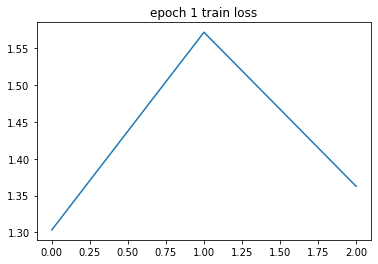

Valid Epoch 1: [3/3](100%)	 Loss: 1.412791
Valid Epoch 1: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 2: [2/6 (33%)]	Loss: 1.546795
Train Epoch 2: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]
Train Epoch 2: [4/6 (67%)]	Loss: 1.402188
Train Epoch 2: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]
Train Epoch 2: [6/6 (100%)]	Loss: 1.393181
Train Epoch 2: Acc: 16.67%	macro metrics: [p: 0.1111, r:0.1667, f1:0.1333]


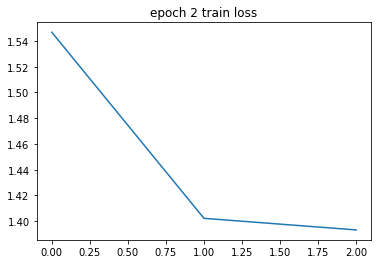

Valid Epoch 2: [3/3](100%)	 Loss: 1.372569
Valid Epoch 2: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 3: [2/6 (33%)]	Loss: 1.420439
Train Epoch 3: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]
Train Epoch 3: [4/6 (67%)]	Loss: 1.352883
Train Epoch 3: Acc: 25.00%	macro metrics: [p: 0.1667, r:0.1667, f1:0.1667]
Train Epoch 3: [6/6 (100%)]	Loss: 1.293002
Train Epoch 3: Acc: 33.33%	macro metrics: [p: 0.2778, r:0.3333, f1:0.3000]


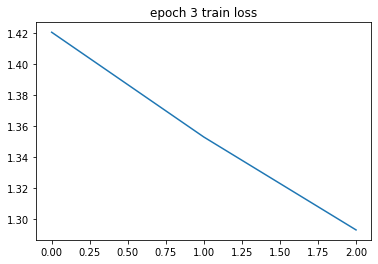

Valid Epoch 3: [3/3](100%)	 Loss: 1.400393
Valid Epoch 3: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 4: [2/6 (33%)]	Loss: 1.301011
Train Epoch 4: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 4: [4/6 (67%)]	Loss: 1.412940
Train Epoch 4: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.5000, f1:0.3889]
Train Epoch 4: [6/6 (100%)]	Loss: 1.402820
Train Epoch 4: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.5000, f1:0.4000]


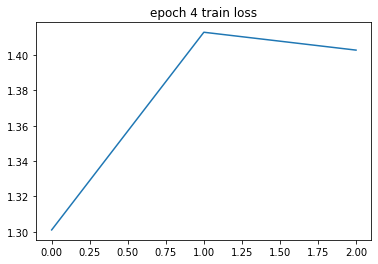

Valid Epoch 4: [3/3](100%)	 Loss: 1.354187
Valid Epoch 4: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 5: [2/6 (33%)]	Loss: 1.328343
Train Epoch 5: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.3333, f1:0.3333]
Train Epoch 5: [4/6 (67%)]	Loss: 1.281852
Train Epoch 5: Acc: 50.00%	macro metrics: [p: 0.2222, r:0.3333, f1:0.2667]
Train Epoch 5: [6/6 (100%)]	Loss: 1.306084
Train Epoch 5: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.5000, f1:0.4000]


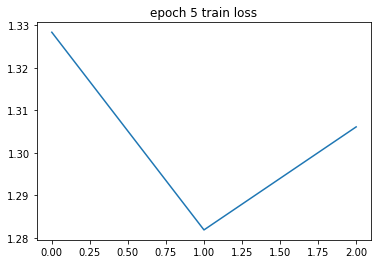

Valid Epoch 5: [3/3](100%)	 Loss: 1.390534
Valid Epoch 5: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 6: [2/6 (33%)]	Loss: 1.232519
Train Epoch 6: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 6: [4/6 (67%)]	Loss: 1.281206
Train Epoch 6: Acc: 75.00%	macro metrics: [p: 0.5556, r:0.6667, f1:0.6000]
Train Epoch 6: [6/6 (100%)]	Loss: 1.412320
Train Epoch 6: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.5000, f1:0.3889]


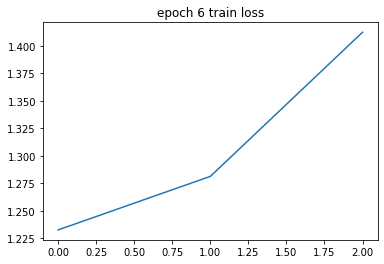

Valid Epoch 6: [3/3](100%)	 Loss: 1.356774
Valid Epoch 6: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 7: [2/6 (33%)]	Loss: 1.285809
Train Epoch 7: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 7: [4/6 (67%)]	Loss: 1.401992
Train Epoch 7: Acc: 50.00%	macro metrics: [p: 0.6667, r:0.3333, f1:0.4444]
Train Epoch 7: [6/6 (100%)]	Loss: 1.150772
Train Epoch 7: Acc: 66.67%	macro metrics: [p: 0.8333, r:0.6667, f1:0.6667]


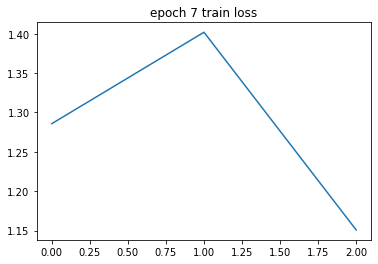

Valid Epoch 7: [3/3](100%)	 Loss: 1.353843
Valid Epoch 7: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 8: [2/6 (33%)]	Loss: 1.123840
Train Epoch 8: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 8: [4/6 (67%)]	Loss: 1.403292
Train Epoch 8: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.5000, f1:0.3889]
Train Epoch 8: [6/6 (100%)]	Loss: 1.291761
Train Epoch 8: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.5000, f1:0.4000]


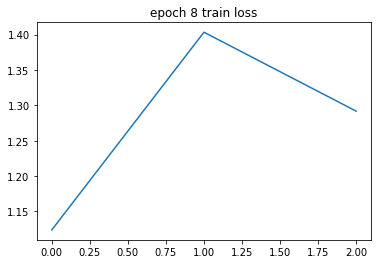

Valid Epoch 8: [3/3](100%)	 Loss: 1.349653
Valid Epoch 8: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 9: [2/6 (33%)]	Loss: 1.167227
Train Epoch 9: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 9: [4/6 (67%)]	Loss: 1.212532
Train Epoch 9: Acc: 75.00%	macro metrics: [p: 0.5556, r:0.6667, f1:0.6000]
Train Epoch 9: [6/6 (100%)]	Loss: 1.321439
Train Epoch 9: Acc: 66.67%	macro metrics: [p: 0.5000, r:0.6667, f1:0.5556]


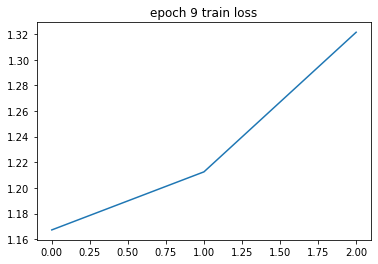

Valid Epoch 9: [3/3](100%)	 Loss: 1.371197
Valid Epoch 9: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 10: [2/6 (33%)]	Loss: 1.348774
Train Epoch 10: Acc: 50.00%	macro metrics: [p: 0.5000, r:0.2500, f1:0.3333]
Train Epoch 10: [4/6 (67%)]	Loss: 1.212940
Train Epoch 10: Acc: 50.00%	macro metrics: [p: 0.4444, r:0.5000, f1:0.3889]
Train Epoch 10: [6/6 (100%)]	Loss: 1.228022
Train Epoch 10: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.5000, f1:0.3889]


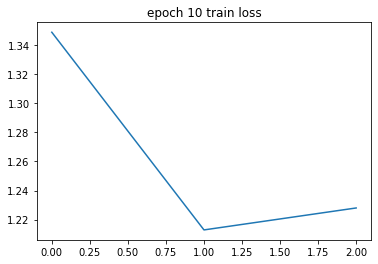

Valid Epoch 10: [3/3](100%)	 Loss: 1.341423
Valid Epoch 10: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 11: [2/6 (33%)]	Loss: 1.170549
Train Epoch 11: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 11: [4/6 (67%)]	Loss: 1.382546
Train Epoch 11: Acc: 25.00%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]
Train Epoch 11: [6/6 (100%)]	Loss: 1.208541
Train Epoch 11: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.5000, f1:0.3889]


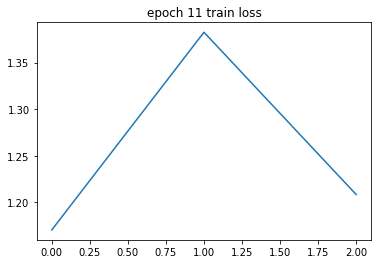

Valid Epoch 11: [3/3](100%)	 Loss: 1.340842
Valid Epoch 11: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 12: [2/6 (33%)]	Loss: 1.187476
Train Epoch 12: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 12: [4/6 (67%)]	Loss: 1.343811
Train Epoch 12: Acc: 75.00%	macro metrics: [p: 0.5556, r:0.6667, f1:0.6000]
Train Epoch 12: [6/6 (100%)]	Loss: 1.301821
Train Epoch 12: Acc: 66.67%	macro metrics: [p: 0.4444, r:0.6667, f1:0.5333]


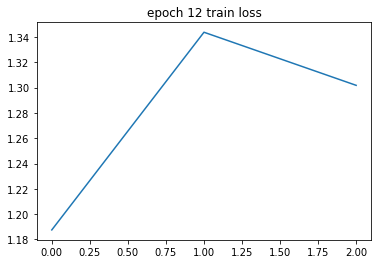

Valid Epoch 12: [3/3](100%)	 Loss: 1.341281
Valid Epoch 12: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 13: [2/6 (33%)]	Loss: 0.996723
Train Epoch 13: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.3333, f1:0.3333]
Train Epoch 13: [4/6 (67%)]	Loss: 1.276952
Train Epoch 13: Acc: 50.00%	macro metrics: [p: 0.4444, r:0.6667, f1:0.5000]
Train Epoch 13: [6/6 (100%)]	Loss: 1.259002
Train Epoch 13: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.5000, f1:0.4000]


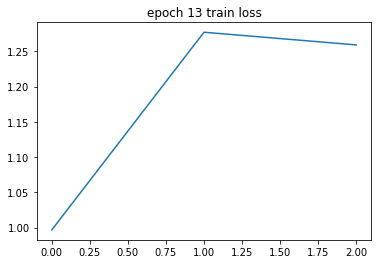

Valid Epoch 13: [3/3](100%)	 Loss: 1.337941
Valid Epoch 13: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 14: [2/6 (33%)]	Loss: 1.202880
Train Epoch 14: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.3333, f1:0.3333]
Train Epoch 14: [4/6 (67%)]	Loss: 1.116459
Train Epoch 14: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.6667, f1:0.4444]
Train Epoch 14: [6/6 (100%)]	Loss: 1.106233
Train Epoch 14: Acc: 66.67%	macro metrics: [p: 0.4444, r:0.6667, f1:0.5333]


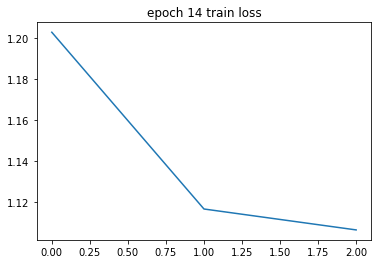

Valid Epoch 14: [3/3](100%)	 Loss: 1.350098
Valid Epoch 14: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 15: [2/6 (33%)]	Loss: 1.295019
Train Epoch 15: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]
Train Epoch 15: [4/6 (67%)]	Loss: 1.042253
Train Epoch 15: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.3333, f1:0.3333]
Train Epoch 15: [6/6 (100%)]	Loss: 1.250043
Train Epoch 15: Acc: 50.00%	macro metrics: [p: 0.4444, r:0.5000, f1:0.4667]


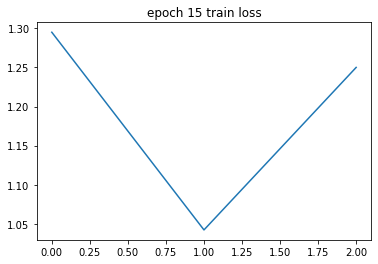

Valid Epoch 15: [3/3](100%)	 Loss: 1.326880
Valid Epoch 15: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 16: [2/6 (33%)]	Loss: 0.975098
Train Epoch 16: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 16: [4/6 (67%)]	Loss: 1.433499
Train Epoch 16: Acc: 50.00%	macro metrics: [p: 0.1667, r:0.3333, f1:0.2222]
Train Epoch 16: [6/6 (100%)]	Loss: 1.424143
Train Epoch 16: Acc: 33.33%	macro metrics: [p: 0.1333, r:0.3333, f1:0.1905]


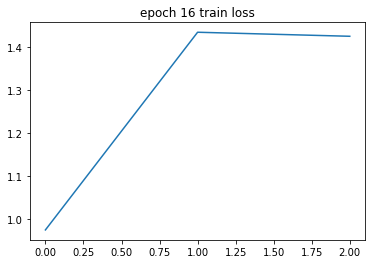

Valid Epoch 16: [3/3](100%)	 Loss: 1.341266
Valid Epoch 16: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 17: [2/6 (33%)]	Loss: 1.328456
Train Epoch 17: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]
Train Epoch 17: [4/6 (67%)]	Loss: 1.271672
Train Epoch 17: Acc: 25.00%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]
Train Epoch 17: [6/6 (100%)]	Loss: 1.071290
Train Epoch 17: Acc: 33.33%	macro metrics: [p: 0.1667, r:0.3333, f1:0.2222]


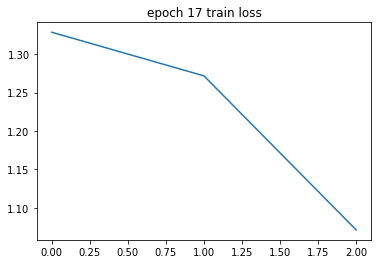

Valid Epoch 17: [3/3](100%)	 Loss: 1.320946
Valid Epoch 17: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 18: [2/6 (33%)]	Loss: 1.237449
Train Epoch 18: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]
Train Epoch 18: [4/6 (67%)]	Loss: 1.099486
Train Epoch 18: Acc: 50.00%	macro metrics: [p: 0.4444, r:0.6667, f1:0.5000]
Train Epoch 18: [6/6 (100%)]	Loss: 1.156803
Train Epoch 18: Acc: 66.67%	macro metrics: [p: 0.5000, r:0.6667, f1:0.5556]


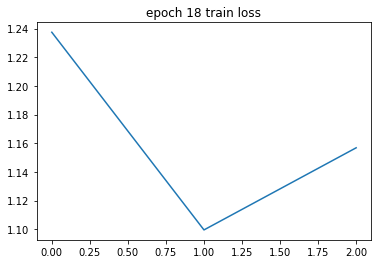

Valid Epoch 18: [3/3](100%)	 Loss: 1.319253
Valid Epoch 18: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 19: [2/6 (33%)]	Loss: 1.128426
Train Epoch 19: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 19: [4/6 (67%)]	Loss: 1.282750
Train Epoch 19: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.5000, f1:0.3889]
Train Epoch 19: [6/6 (100%)]	Loss: 0.871936
Train Epoch 19: Acc: 66.67%	macro metrics: [p: 0.7222, r:0.6667, f1:0.6556]


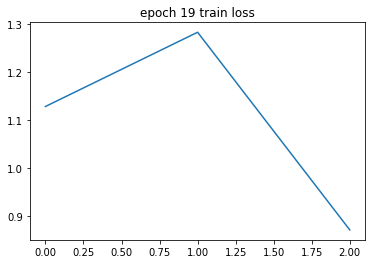

Valid Epoch 19: [3/3](100%)	 Loss: 1.336150
Valid Epoch 19: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 20: [2/6 (33%)]	Loss: 0.963778
Train Epoch 20: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 20: [4/6 (67%)]	Loss: 1.203750
Train Epoch 20: Acc: 50.00%	macro metrics: [p: 0.5000, r:0.5000, f1:0.5000]
Train Epoch 20: [6/6 (100%)]	Loss: 1.088870
Train Epoch 20: Acc: 66.67%	macro metrics: [p: 0.6667, r:0.6667, f1:0.6667]


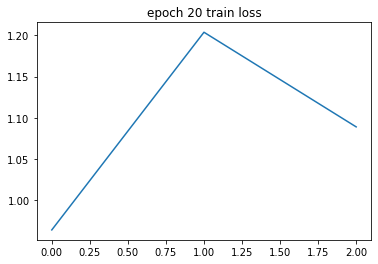

Valid Epoch 20: [3/3](100%)	 Loss: 1.335821
Valid Epoch 20: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 21: [2/6 (33%)]	Loss: 1.046166
Train Epoch 21: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 21: [4/6 (67%)]	Loss: 1.120046
Train Epoch 21: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.5000, f1:0.3889]
Train Epoch 21: [6/6 (100%)]	Loss: 1.197048
Train Epoch 21: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.5000, f1:0.3889]


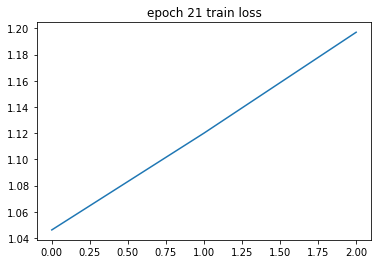

Valid Epoch 21: [3/3](100%)	 Loss: 1.366189
Valid Epoch 21: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 22: [2/6 (33%)]	Loss: 1.353636
Train Epoch 22: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]
Train Epoch 22: [4/6 (67%)]	Loss: 0.990590
Train Epoch 22: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.3333, f1:0.3333]
Train Epoch 22: [6/6 (100%)]	Loss: 1.201295
Train Epoch 22: Acc: 33.33%	macro metrics: [p: 0.3333, r:0.3333, f1:0.3333]


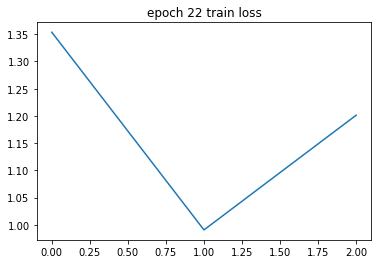

Valid Epoch 22: [3/3](100%)	 Loss: 1.315244
Valid Epoch 22: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 23: [2/6 (33%)]	Loss: 1.218105
Train Epoch 23: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.3333, f1:0.3333]
Train Epoch 23: [4/6 (67%)]	Loss: 0.941355
Train Epoch 23: Acc: 75.00%	macro metrics: [p: 0.8333, r:0.8333, f1:0.7778]
Train Epoch 23: [6/6 (100%)]	Loss: 1.066379
Train Epoch 23: Acc: 83.33%	macro metrics: [p: 0.8889, r:0.8333, f1:0.8222]


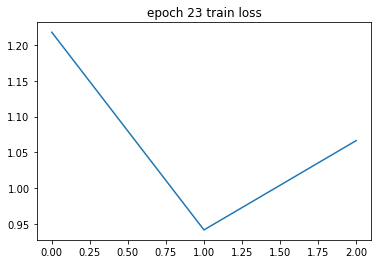

Valid Epoch 23: [3/3](100%)	 Loss: 1.313860
Valid Epoch 23: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 24: [2/6 (33%)]	Loss: 0.927786
Train Epoch 24: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 24: [4/6 (67%)]	Loss: 1.243960
Train Epoch 24: Acc: 50.00%	macro metrics: [p: 0.2222, r:0.3333, f1:0.2667]
Train Epoch 24: [6/6 (100%)]	Loss: 1.122083
Train Epoch 24: Acc: 66.67%	macro metrics: [p: 0.4444, r:0.6667, f1:0.5333]


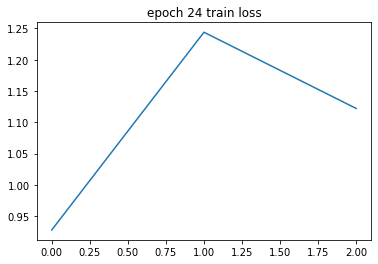

Valid Epoch 24: [3/3](100%)	 Loss: 1.333512
Valid Epoch 24: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 25: [2/6 (33%)]	Loss: 0.825357
Train Epoch 25: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 25: [4/6 (67%)]	Loss: 1.195464
Train Epoch 25: Acc: 50.00%	macro metrics: [p: 0.2222, r:0.3333, f1:0.2667]
Train Epoch 25: [6/6 (100%)]	Loss: 1.005182
Train Epoch 25: Acc: 66.67%	macro metrics: [p: 0.4444, r:0.6667, f1:0.5333]


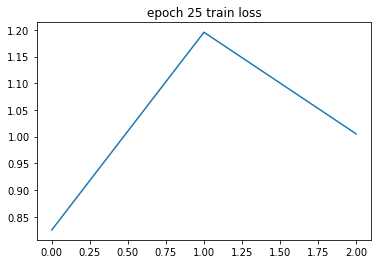

Valid Epoch 25: [3/3](100%)	 Loss: 1.311922
Valid Epoch 25: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 26: [2/6 (33%)]	Loss: 0.993797
Train Epoch 26: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 26: [4/6 (67%)]	Loss: 1.061900
Train Epoch 26: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 26: [6/6 (100%)]	Loss: 1.256507
Train Epoch 26: Acc: 33.33%	macro metrics: [p: 0.1333, r:0.3333, f1:0.1905]


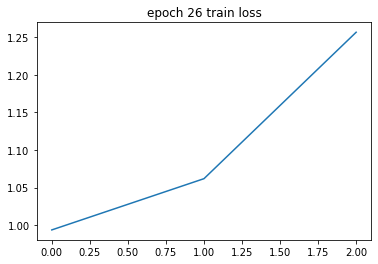

Valid Epoch 26: [3/3](100%)	 Loss: 1.387042
Valid Epoch 26: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 27: [2/6 (33%)]	Loss: 0.741930
Train Epoch 27: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 27: [4/6 (67%)]	Loss: 1.166363
Train Epoch 27: Acc: 75.00%	macro metrics: [p: 0.8333, r:0.7500, f1:0.7333]
Train Epoch 27: [6/6 (100%)]	Loss: 1.096433
Train Epoch 27: Acc: 83.33%	macro metrics: [p: 0.8889, r:0.8333, f1:0.8222]


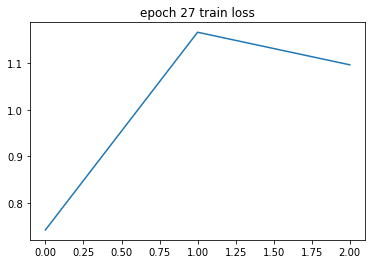

Valid Epoch 27: [3/3](100%)	 Loss: 1.309122
Valid Epoch 27: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 28: [2/6 (33%)]	Loss: 1.115348
Train Epoch 28: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 28: [4/6 (67%)]	Loss: 1.076958
Train Epoch 28: Acc: 75.00%	macro metrics: [p: 0.5000, r:0.6667, f1:0.5556]
Train Epoch 28: [6/6 (100%)]	Loss: 0.978939
Train Epoch 28: Acc: 66.67%	macro metrics: [p: 0.5000, r:0.6667, f1:0.5556]


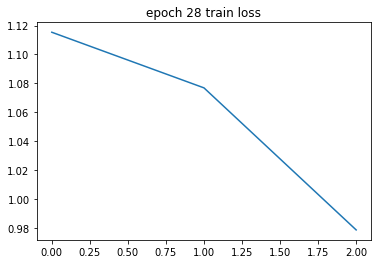

Valid Epoch 28: [3/3](100%)	 Loss: 1.326002
Valid Epoch 28: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 29: [2/6 (33%)]	Loss: 0.630078
Train Epoch 29: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 29: [4/6 (67%)]	Loss: 0.940838
Train Epoch 29: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 29: [6/6 (100%)]	Loss: 1.172773
Train Epoch 29: Acc: 66.67%	macro metrics: [p: 0.6667, r:0.6667, f1:0.6667]


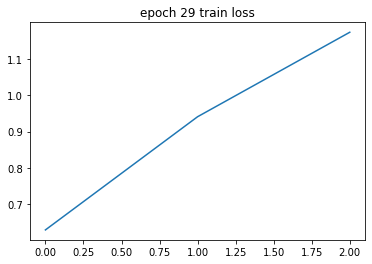

Valid Epoch 29: [3/3](100%)	 Loss: 1.324669
Valid Epoch 29: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 30: [2/6 (33%)]	Loss: 0.867057
Train Epoch 30: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 30: [4/6 (67%)]	Loss: 1.141552
Train Epoch 30: Acc: 75.00%	macro metrics: [p: 0.5000, r:0.6667, f1:0.5556]
Train Epoch 30: [6/6 (100%)]	Loss: 1.163906
Train Epoch 30: Acc: 83.33%	macro metrics: [p: 0.8889, r:0.8333, f1:0.8222]


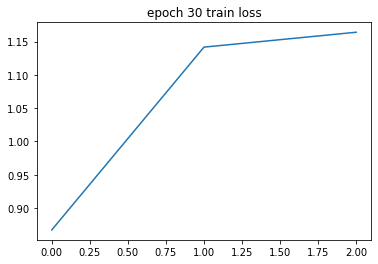

Valid Epoch 30: [3/3](100%)	 Loss: 1.398061
Valid Epoch 30: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 31: [2/6 (33%)]	Loss: 0.884469
Train Epoch 31: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 31: [4/6 (67%)]	Loss: 1.156621
Train Epoch 31: Acc: 50.00%	macro metrics: [p: 0.5000, r:0.5000, f1:0.5000]
Train Epoch 31: [6/6 (100%)]	Loss: 1.165011
Train Epoch 31: Acc: 33.33%	macro metrics: [p: 0.4444, r:0.3333, f1:0.3556]


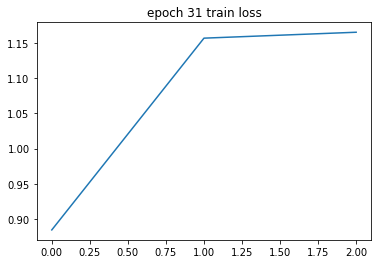

Valid Epoch 31: [3/3](100%)	 Loss: 1.325742
Valid Epoch 31: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 32: [2/6 (33%)]	Loss: 1.108391
Train Epoch 32: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.3333, f1:0.3333]
Train Epoch 32: [4/6 (67%)]	Loss: 1.058245
Train Epoch 32: Acc: 75.00%	macro metrics: [p: 0.5556, r:0.6667, f1:0.6000]
Train Epoch 32: [6/6 (100%)]	Loss: 0.994948
Train Epoch 32: Acc: 66.67%	macro metrics: [p: 0.4444, r:0.6667, f1:0.5333]


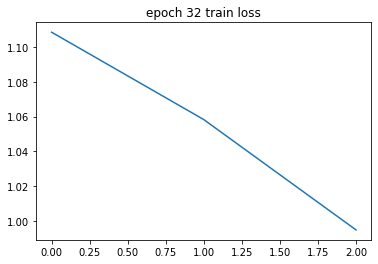

Valid Epoch 32: [3/3](100%)	 Loss: 1.307524
Valid Epoch 32: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 33: [2/6 (33%)]	Loss: 0.780187
Train Epoch 33: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 33: [4/6 (67%)]	Loss: 0.573619
Train Epoch 33: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 33: [6/6 (100%)]	Loss: 1.252753
Train Epoch 33: Acc: 66.67%	macro metrics: [p: 0.5000, r:0.6667, f1:0.5556]


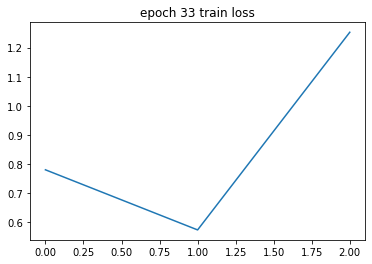

Valid Epoch 33: [3/3](100%)	 Loss: 1.306675
Valid Epoch 33: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 34: [2/6 (33%)]	Loss: 0.814520
Train Epoch 34: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 34: [4/6 (67%)]	Loss: 0.701894
Train Epoch 34: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 34: [6/6 (100%)]	Loss: 1.195877
Train Epoch 34: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]


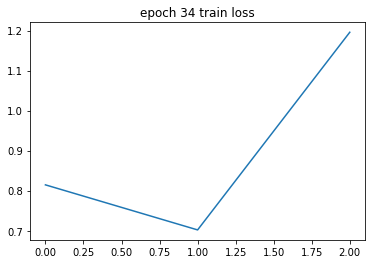

Valid Epoch 34: [3/3](100%)	 Loss: 1.430919
Valid Epoch 34: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 35: [2/6 (33%)]	Loss: 0.883871
Train Epoch 35: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 35: [4/6 (67%)]	Loss: 1.179422
Train Epoch 35: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 35: [6/6 (100%)]	Loss: 0.661851
Train Epoch 35: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]


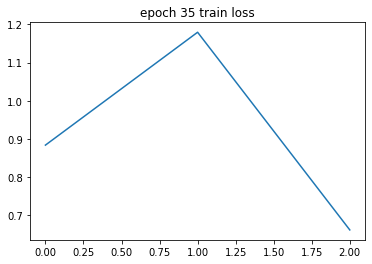

Valid Epoch 35: [3/3](100%)	 Loss: 1.322910
Valid Epoch 35: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 36: [2/6 (33%)]	Loss: 1.031084
Train Epoch 36: Acc: 50.00%	macro metrics: [p: 0.5000, r:0.2500, f1:0.3333]
Train Epoch 36: [4/6 (67%)]	Loss: 0.934998
Train Epoch 36: Acc: 75.00%	macro metrics: [p: 0.8333, r:0.8333, f1:0.7778]
Train Epoch 36: [6/6 (100%)]	Loss: 0.825268
Train Epoch 36: Acc: 83.33%	macro metrics: [p: 0.8889, r:0.8333, f1:0.8222]


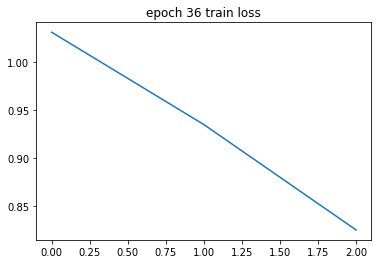

Valid Epoch 36: [3/3](100%)	 Loss: 1.320195
Valid Epoch 36: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 37: [2/6 (33%)]	Loss: 0.813452
Train Epoch 37: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 37: [4/6 (67%)]	Loss: 0.838159
Train Epoch 37: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 37: [6/6 (100%)]	Loss: 0.962866
Train Epoch 37: Acc: 83.33%	macro metrics: [p: 0.8889, r:0.8333, f1:0.8222]


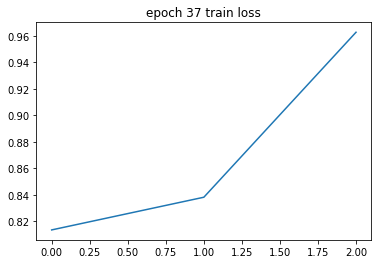

Valid Epoch 37: [3/3](100%)	 Loss: 1.305135
Valid Epoch 37: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 38: [2/6 (33%)]	Loss: 0.948800
Train Epoch 38: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 38: [4/6 (67%)]	Loss: 0.574642
Train Epoch 38: Acc: 75.00%	macro metrics: [p: 0.8333, r:0.8333, f1:0.7778]
Train Epoch 38: [6/6 (100%)]	Loss: 0.496744
Train Epoch 38: Acc: 83.33%	macro metrics: [p: 0.8889, r:0.8333, f1:0.8222]


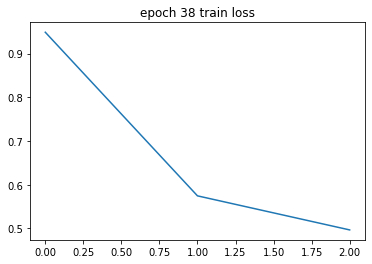

Valid Epoch 38: [3/3](100%)	 Loss: 1.319144
Valid Epoch 38: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 39: [2/6 (33%)]	Loss: 0.769806
Train Epoch 39: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 39: [4/6 (67%)]	Loss: 0.959521
Train Epoch 39: Acc: 75.00%	macro metrics: [p: 0.5556, r:0.6667, f1:0.6000]
Train Epoch 39: [6/6 (100%)]	Loss: 0.701500
Train Epoch 39: Acc: 66.67%	macro metrics: [p: 0.4444, r:0.6667, f1:0.5333]


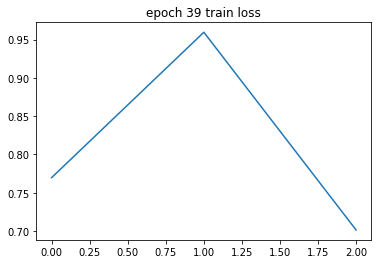

Valid Epoch 39: [3/3](100%)	 Loss: 1.319780
Valid Epoch 39: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 40: [2/6 (33%)]	Loss: 0.725771
Train Epoch 40: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 40: [4/6 (67%)]	Loss: 0.799530
Train Epoch 40: Acc: 75.00%	macro metrics: [p: 0.5556, r:0.6667, f1:0.6000]
Train Epoch 40: [6/6 (100%)]	Loss: 0.708343
Train Epoch 40: Acc: 83.33%	macro metrics: [p: 0.8889, r:0.8333, f1:0.8222]


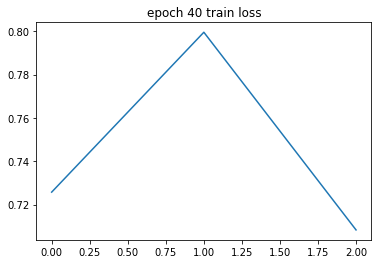

Valid Epoch 40: [3/3](100%)	 Loss: 1.318287
Valid Epoch 40: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 41: [2/6 (33%)]	Loss: 0.856336
Train Epoch 41: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 41: [4/6 (67%)]	Loss: 1.244391
Train Epoch 41: Acc: 25.00%	macro metrics: [p: 0.1111, r:0.1667, f1:0.1333]
Train Epoch 41: [6/6 (100%)]	Loss: 0.742421
Train Epoch 41: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.5000, f1:0.4000]


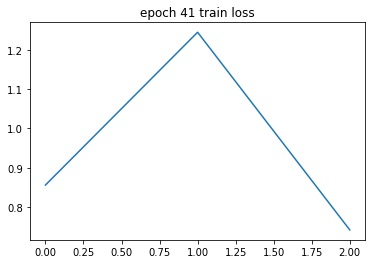

Valid Epoch 41: [3/3](100%)	 Loss: 1.472087
Valid Epoch 41: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 42: [2/6 (33%)]	Loss: 1.152935
Train Epoch 42: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.3333, f1:0.3333]
Train Epoch 42: [4/6 (67%)]	Loss: 0.706621
Train Epoch 42: Acc: 50.00%	macro metrics: [p: 0.4444, r:0.6667, f1:0.5000]
Train Epoch 42: [6/6 (100%)]	Loss: 0.984954
Train Epoch 42: Acc: 50.00%	macro metrics: [p: 0.5000, r:0.5000, f1:0.4444]


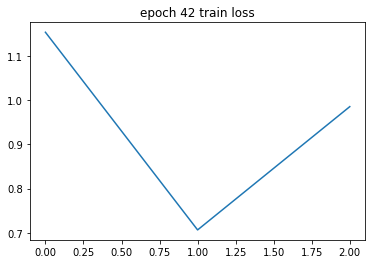

Valid Epoch 42: [3/3](100%)	 Loss: 1.306959
Valid Epoch 42: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 43: [2/6 (33%)]	Loss: 0.618516
Train Epoch 43: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 43: [4/6 (67%)]	Loss: 0.726231
Train Epoch 43: Acc: 75.00%	macro metrics: [p: 0.5000, r:0.6667, f1:0.5556]
Train Epoch 43: [6/6 (100%)]	Loss: 0.749299
Train Epoch 43: Acc: 83.33%	macro metrics: [p: 0.8889, r:0.8333, f1:0.8222]


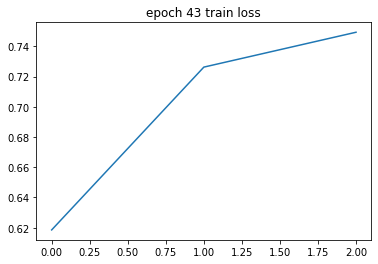

Valid Epoch 43: [3/3](100%)	 Loss: 1.492610
Valid Epoch 43: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 44: [2/6 (33%)]	Loss: 1.069246
Train Epoch 44: Acc: 50.00%	macro metrics: [p: 0.5000, r:0.2500, f1:0.3333]
Train Epoch 44: [4/6 (67%)]	Loss: 0.512246
Train Epoch 44: Acc: 75.00%	macro metrics: [p: 0.8333, r:0.8333, f1:0.7778]
Train Epoch 44: [6/6 (100%)]	Loss: 0.735371
Train Epoch 44: Acc: 66.67%	macro metrics: [p: 0.7222, r:0.6667, f1:0.6556]


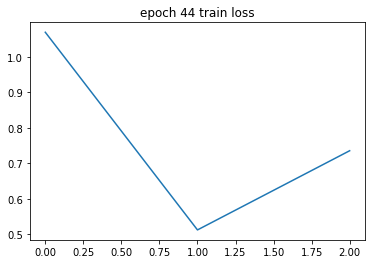

Valid Epoch 44: [3/3](100%)	 Loss: 1.325846
Valid Epoch 44: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 45: [2/6 (33%)]	Loss: 0.827140
Train Epoch 45: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 45: [4/6 (67%)]	Loss: 1.049753
Train Epoch 45: Acc: 25.00%	macro metrics: [p: 0.1667, r:0.3333, f1:0.2222]
Train Epoch 45: [6/6 (100%)]	Loss: 0.548599
Train Epoch 45: Acc: 50.00%	macro metrics: [p: 0.3889, r:0.5000, f1:0.4333]


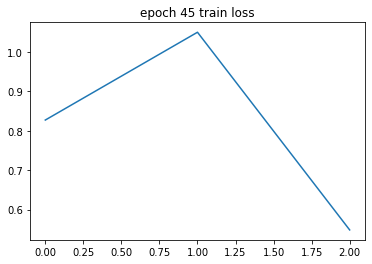

Valid Epoch 45: [3/3](100%)	 Loss: 1.510417
Valid Epoch 45: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 46: [2/6 (33%)]	Loss: 0.626614
Train Epoch 46: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 46: [4/6 (67%)]	Loss: 0.907321
Train Epoch 46: Acc: 75.00%	macro metrics: [p: 0.8333, r:0.8333, f1:0.7778]
Train Epoch 46: [6/6 (100%)]	Loss: 0.676533
Train Epoch 46: Acc: 83.33%	macro metrics: [p: 0.8889, r:0.8333, f1:0.8222]


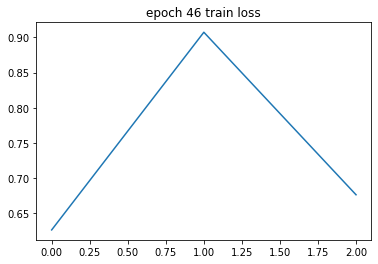

Valid Epoch 46: [3/3](100%)	 Loss: 1.329051
Valid Epoch 46: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 47: [2/6 (33%)]	Loss: 1.017094
Train Epoch 47: Acc: 50.00%	macro metrics: [p: 0.5000, r:0.2500, f1:0.3333]
Train Epoch 47: [4/6 (67%)]	Loss: 0.922921
Train Epoch 47: Acc: 75.00%	macro metrics: [p: 0.8333, r:0.7500, f1:0.7333]
Train Epoch 47: [6/6 (100%)]	Loss: 0.291679
Train Epoch 47: Acc: 83.33%	macro metrics: [p: 0.8889, r:0.8333, f1:0.8222]


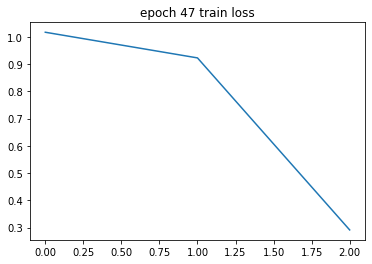

Valid Epoch 47: [3/3](100%)	 Loss: 1.329517
Valid Epoch 47: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 48: [2/6 (33%)]	Loss: 0.749481
Train Epoch 48: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 48: [4/6 (67%)]	Loss: 0.758914
Train Epoch 48: Acc: 50.00%	macro metrics: [p: 0.2222, r:0.3333, f1:0.2667]
Train Epoch 48: [6/6 (100%)]	Loss: 0.847249
Train Epoch 48: Acc: 50.00%	macro metrics: [p: 0.3889, r:0.5000, f1:0.4333]


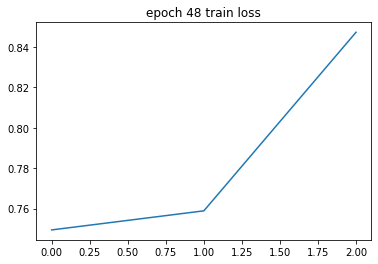

Valid Epoch 48: [3/3](100%)	 Loss: 1.315814
Valid Epoch 48: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 49: [2/6 (33%)]	Loss: 0.812767
Train Epoch 49: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 49: [4/6 (67%)]	Loss: 0.427804
Train Epoch 49: Acc: 75.00%	macro metrics: [p: 0.5000, r:0.6667, f1:0.5556]
Train Epoch 49: [6/6 (100%)]	Loss: 0.856969
Train Epoch 49: Acc: 83.33%	macro metrics: [p: 0.8889, r:0.8333, f1:0.8222]


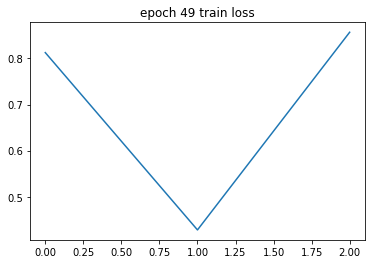

Valid Epoch 49: [3/3](100%)	 Loss: 1.316068
Valid Epoch 49: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]


Train Epoch 50: [2/6 (33%)]	Loss: 1.020347
Train Epoch 50: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 50: [4/6 (67%)]	Loss: 0.746188
Train Epoch 50: Acc: 75.00%	macro metrics: [p: 0.5556, r:0.6667, f1:0.6000]
Train Epoch 50: [6/6 (100%)]	Loss: 0.561292
Train Epoch 50: Acc: 83.33%	macro metrics: [p: 0.8889, r:0.8333, f1:0.8222]


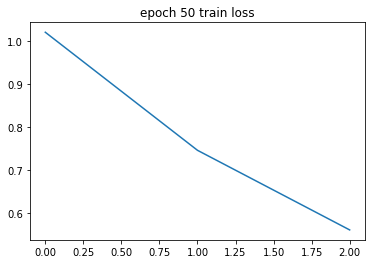

Valid Epoch 50: [3/3](100%)	 Loss: 1.316391
Valid Epoch 50: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]




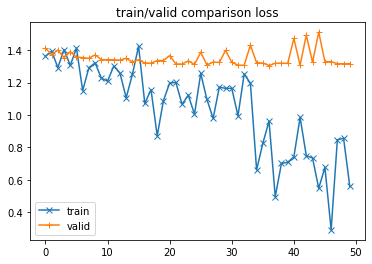

best(valid loss quota) early stopping epoch: 37, this epoch macro f1: 0.0000
total 50 epochs, best(valid macro f1) epoch: 1, this epoch macro f1: 0.1667
after 50 epochs, final test data macro f1: 0.2222


In [16]:
# main entry, define optimization function, loss function and so on
# start epoch
# Use the loss of the valid dataset to make an early stop judgment. When it does not decline, this is the time when the model generalization is the best.
model = PCNN(cfg)
print(model)

optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=cfg.lr_factor, patience=cfg.lr_patience)
criterion = nn.CrossEntropyLoss()

best_f1, best_epoch = -1, 0
es_loss, es_f1, es_epoch, es_patience, best_es_epoch, best_es_f1, = 1000, -1, 0, 0, 0, -1
train_losses, valid_losses = [], []

logger.info('=' * 10 + ' Start training ' + '=' * 10)
for epoch in range(1, cfg.epoch + 1):
    train_loss = train(epoch, model, train_dataloader, optimizer, criterion, cfg)
    valid_f1, valid_loss = validate(epoch, model, valid_dataloader, criterion)
    scheduler.step(valid_loss)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    if best_f1 < valid_f1:
        best_f1 = valid_f1
        best_epoch = epoch
    # 使用 valid loss 做 early stopping 的判断标准
    if es_loss > valid_loss:
        es_loss = valid_loss
        es_f1 = valid_f1
        best_es_f1 = valid_f1
        es_epoch = epoch
        best_es_epoch = epoch
        es_patience = 0
    else:
        es_patience += 1
        if es_patience >= cfg.early_stopping_patience:
            best_es_epoch = es_epoch
            best_es_f1 = es_f1

if cfg.show_plot:
    if cfg.plot_utils == 'matplot':
        plt.plot(train_losses, 'x-')
        plt.plot(valid_losses, '+-')
        plt.legend(['train', 'valid'])
        plt.title('train/valid comparison loss')
        plt.show()


print(f'best(valid loss quota) early stopping epoch: {best_es_epoch}, '
            f'this epoch macro f1: {best_es_f1:0.4f}')
print(f'total {cfg.epoch} epochs, best(valid macro f1) epoch: {best_epoch}, '
            f'this epoch macro f1: {best_f1:.4f}')

test_f1, _ = validate(0, model, test_dataloader, criterion,verbose=False)
print(f'after {cfg.epoch} epochs, final test data macro f1: {test_f1:.4f}')